# Behavioral Cloning Project

### Load the CSV Data and Fix Paths

In [23]:
import cv2
import csv
import numpy as np
from sklearn.utils import shuffle


samples = []

for datapath in ['./track-1', './track-2']:

    with open('./{}/driving_log.csv'.format(datapath)) as fp:
        reader = csv.reader(fp)

        adjustments = [0, 0.2, -0.2]

        for line in reader:    
            for i in range(3):
                path = './{}/IMG/{}'.format(datapath, line[i].split('/')[-1])
                measurement = float(line[3]) + adjustments[i]
                
                samples.append((path, measurement))

samples = shuffle(samples)
                
num_samples = len(samples)
print('Total samples: {}'.format(len(samples)))

training_samples = samples[:int(num_samples * 0.75)]
num_training_samples = len(training_samples)
print('Training samples: {}'.format(num_training_samples))

validation_samples = samples[int(num_samples * 0.75):]
num_validation_samples = len(validation_samples)
print('Validation samples: {}'.format(num_validation_samples))


Total samples: 39252
Training samples: 29439
Validation samples: 9813


Input shape: (160, 320, 3)


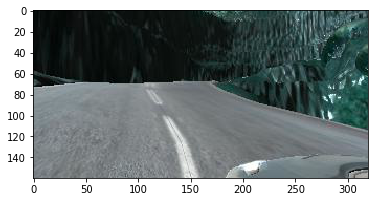

In [24]:
import matplotlib.pyplot as plt


test_image = cv2.imread(samples[0][0])
input_shape = test_image.shape
print('Input shape: {}'.format(input_shape))

plt.imshow(test_image)
plt.show()


### Load Data Set

In [29]:
import math


epochs = 10
batch_size = 512

def batch_generator(samples):

    num_batches = math.ceil(len(samples) / batch_size)
    
    while True:

        for i in range(0, num_batches):

            start = i * batch_size
            end = start + batch_size
            batch = samples[start:end]

            batch_inputs = []
            batch_targets = []

            for path, measurement in batch:
                image = cv2.imread(path)
                image = cv2.GaussianBlur(image, (3,3), 0)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                
                batch_inputs.append(image)
                batch_targets.append(measurement)
                
                batch_inputs.append(np.fliplr(image))
                batch_targets.append(-1.0 * measurement)

            yield (np.array(batch_inputs), np.array(batch_targets))


### Network Architecture

Epoch 1/10
58/58 [==============================] - 129s - loss: 0.0374 - val_loss: 0.0236
Epoch 2/10
58/58 [==============================] - 126s - loss: 0.0220 - val_loss: 0.0191
Epoch 3/10
58/58 [==============================] - 126s - loss: 0.0191 - val_loss: 0.0166
Epoch 4/10
58/58 [==============================] - 126s - loss: 0.0174 - val_loss: 0.0158
Epoch 5/10
58/58 [==============================] - 126s - loss: 0.0162 - val_loss: 0.0149
Epoch 6/10
58/58 [==============================] - 125s - loss: 0.0154 - val_loss: 0.0147
Epoch 7/10
58/58 [==============================] - 125s - loss: 0.0142 - val_loss: 0.0134
Epoch 8/10
58/58 [==============================] - 126s - loss: 0.0134 - val_loss: 0.0130
Epoch 9/10
58/58 [==============================] - 126s - loss: 0.0127 - val_loss: 0.0121
Epoch 10/10
58/58 [==============================] - 126s - loss: 0.0121 - val_loss: 0.0122


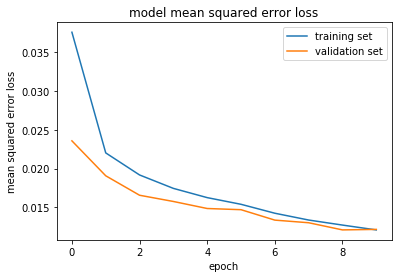

Model saved.


In [30]:
import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Cropping2D


model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=input_shape))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))

model.add(Convolution2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(
    generator=batch_generator(training_samples),
    steps_per_epoch=math.ceil(len(training_samples) / batch_size),
    validation_data=batch_generator(validation_samples),
    validation_steps=math.ceil(len(validation_samples) / batch_size),
    epochs=10,
    initial_epoch=0,
    verbose=1
)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


model.save('model.h5')

print('Model saved.')